In [1]:
# requirements
import numpy as np
import matplotlib.pyplot as plt

In [2]:
w = np.zeros(2)
A = np.array([[3, 0.5], [0.5, 1]])
m = np.array([1, 2])
print(w, A, m)

[0. 0.] [[3.  0.5]
 [0.5 1. ]] [1 2]


In [3]:
rate = 1/np.max(np.linalg.eig(2*A)[0])
print(rate)

0.1603574565909282


In [4]:
# proximal gradient method for lasso
def PGforLasso(lamda):
    w = np.zeros(2)
    # w = np.array([3., -1.])
    w_list = [np.copy(w)]
    times = 0
    l = lamda*rate
    # print(l)
    while 1:
        dw = np.zeros_like(w)
        w_temp = np.copy(w)
        dw = 2*np.dot(A, (w - m).T)
        w -= rate*dw
        for i in range(len(w)):
            if w[i] > l:
                w[i] -= l
            elif w[i] < -l:
                w[i] += l
            else:
                w[i] = 0
        w_list.append(np.copy(w))
        if np.all(w == w_temp) or times == 200:
            print(w)
            break
        times += 1
    print(times)        
    w_list = np.array(w_list)
    w_path_list = np.copy(w_list[:-1])
    w_list = w_list[:-1] - w_list[-1]
    w_list = [np.linalg.norm(i, ord=2) for i in w_list]
    
    x = [i for i in range(len(w_list))]
    plt.semilogy(x, w_list)
    plt.show()
    
    plt.plot(w_path_list[0:-1, 0], w_path_list[0:-1, 1], 'x-')
    plt.plot(w_path_list[-1, 0], w_path_list[-1, 1], 'ro')
    plt.show()

[0.81818182 1.09090909]
106


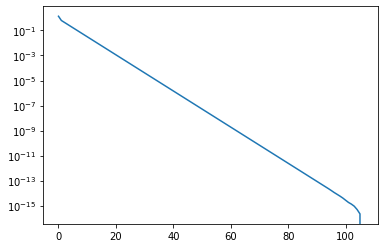

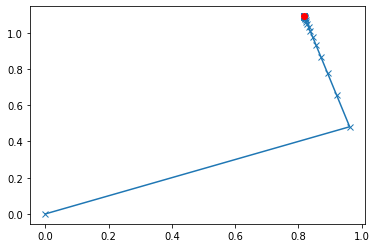

[0.63636364 0.18181818]
97


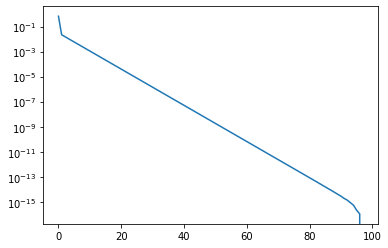

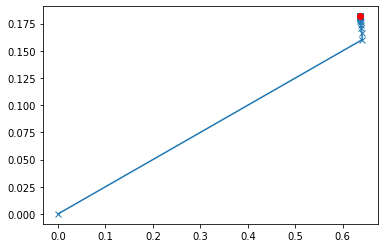

[0.33333333 0.        ]
11


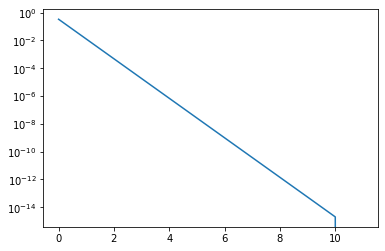

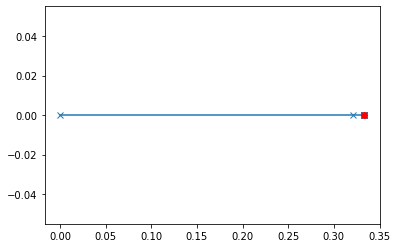

In [5]:
PGforLasso(2)
PGforLasso(4)
PGforLasso(6)

In [6]:
# dataset 6
d_d6 = 200
n_d6 = 180

# we consider 5 groups where each group has 40 attributes
groupSize = 5
attrSize = 40
g_d6 = np.arange(groupSize*attrSize).reshape(groupSize,-1)

x_d6 = np.random.randn(n_d6, d_d6)
noise_d6 = 0.5

# we consider feature in group 1 and group 2 is activated.
w_d6 = np.vstack([20 * np.random.randn(80, 1),
                 np.zeros((120, 1)),
                 5 * np.random.rand()])
x_d6_tilde = np.hstack([x_d6, np.ones((n_d6, 1))])
y_d6 = np.dot(x_d6_tilde, w_d6) + noise_d6 * np.random.randn(n_d6, 1)

In [7]:
def mldivide(A, b):
    piA = np.linalg.pinv(A)
    x = np.dot(piA, b)
    return x

# run the cell which preparing dataset 6 before run this cell
y = y_d6
x_tilde = x_d6_tilde
w = w_d6
noise = noise_d6
n = n_d6
d = d_d6
g = g_d6

lam = 1.0
wridge = mldivide(np.dot(x_tilde.T, x_tilde) + lam * np.eye(d+1), 
                  np.dot(x_tilde.T, y))

# grop lasso with numpy
west = np.zeros([d + 1, 1])
obj_fn = \
  0.5 / n * np.dot(np.dot((np.dot(x_tilde, west) - y).T, np.eye(x_tilde.shape[0])), np.dot(x_tilde, west) - y) + \
  lam * (np.linalg.norm(west[g[0]], 2.0) + \
         np.linalg.norm(west[g[1]], 2.0) + \
         np.linalg.norm(west[g[2]], 2.0) + \
         np.linalg.norm(west[g[3]], 2.0) + \
         np.linalg.norm(west[g[4]], 2.0) )
times = 0
obj = []
while 1:
    if times != 0 : 
        obj_fn_pass = obj_fn[0][0] 
        west_pass = west
    if times > 1: 
        obj_fn_past = obj_fn_pass
        west_past = west_pass
    w_copy = np.copy(west)
    dobj_fn = 1/n*np.dot(x_tilde.T, np.dot(np.eye(x_tilde.shape[0]), np.dot(x_tilde, west) - y))
    west -= 0.01*dobj_fn
    for i in range(5):
        norm = np.linalg.norm(west[g[i]], 2.0)
        if np.all(west[g[i]] == 0):
            west[g[i]] = 0
        else:
            west[g[i]] = max(0, 1 - 0.01*lam/norm)*west[g[i]]
    obj_fn = \
  0.5 / n * np.dot(np.dot((np.dot(x_tilde, west) - y).T, np.eye(x_tilde.shape[0])), np.dot(x_tilde, west) - y) + \
  lam * (np.linalg.norm(west[g[0]], 2.0) + \
         np.linalg.norm(west[g[1]], 2.0) + \
         np.linalg.norm(west[g[2]], 2.0) + \
         np.linalg.norm(west[g[3]], 2.0) + \
         np.linalg.norm(west[g[4]], 2.0) )
    obj.append(obj_fn[0][0])
    if times > 1 and obj_fn_pass < obj_fn[0][0] or times >= 100000:
    # if np.all(west == w_copy) or times == 100000:
        west = west_pass
        # print(west)
        print(times)
        # print(obj_fn_pass)
        break
    times += 1
        
# test
x_test = np.random.randn(n, d)
x_test_tilde = np.hstack([x_test, np.ones((n, 1))])
y_test = np.dot(x_test_tilde, w) + noise * np.random.randn(n, 1)
y_pred = np.dot(x_test_tilde, west)
print(np.mean((y_pred - y_test)**2))


16255
8.667104064206908


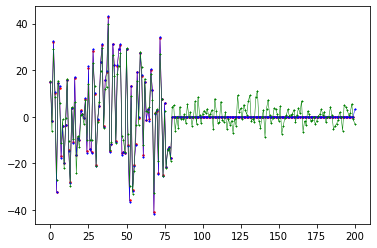

In [8]:
plt.plot(west[0:d], 'r-o', markersize=1.5, linewidth=0.5)
plt.plot(w, 'b-*', markersize=1.5, linewidth=0.5)
plt.plot(wridge, 'g-+', markersize=1.5, linewidth=0.5)
plt.show()

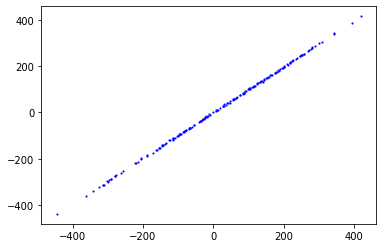

In [9]:
plt.plot(y_test, y_pred, 'bs', markersize=1)

In [10]:
west_np = west

In [11]:
import cvxpy as cv
import matplotlib.pyplot as plt

def mldivide(A, b):
    piA = np.linalg.pinv(A)
    x = np.dot(piA, b)
    return x

# run the cell which preparing dataset 6 before run this cell
y = y_d6
x_tilde = x_d6_tilde
w = w_d6
noise = noise_d6
n = n_d6
d = d_d6
g = g_d6

lam = 1.0
wridge = mldivide(np.dot(x_tilde.T, x_tilde) + lam * np.eye(d+1), 
                  np.dot(x_tilde.T, y))

# cvx
west = cv.Variable((d+1,1))
obj_fn = \
  0.5 / n * cv.quad_form(x_tilde * west - y, np.eye(x_tilde.shape[0])) + \
  lam * (cv.norm(west[g[0]], 2.0) + \
         cv.norm(west[g[1]], 2.0) + \
         cv.norm(west[g[2]], 2.0) + \
         cv.norm(west[g[3]], 2.0) + \
         cv.norm(west[g[4]], 2.0) )
  
objective = cv.Minimize(obj_fn)
constraints = []

prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT)

# test
x_test = np.random.randn(n, d)
x_test_tilde = np.hstack([x_test, np.ones((n, 1))])
y_test = np.dot(x_test_tilde, w) + noise * np.random.randn(n, 1)
y_pred = np.dot(x_test_tilde, west.value)
print(np.mean((y_pred - y_test)**2))

10.296815153735416


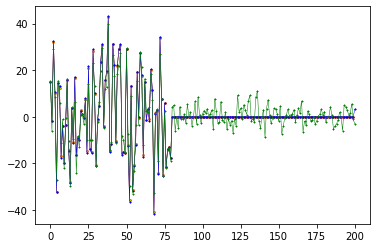

In [15]:
plt.plot(west.value[0:d], 'r-o', markersize=1.5, linewidth=0.5)
plt.plot(west_np[0:d], 'y-x', markersize=1.5, linewidth=0.5)
plt.plot(w, 'b-*', markersize=1.5, linewidth=0.5)
plt.plot(wridge, 'g-+', markersize=1.5, linewidth=0.5)
plt.show()